In [70]:
import epmwebapi as epm
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set(style="whitegrid")
%matplotlib inline

In [71]:
import os
credentials = os.environ.get('user_and_password_dili').split(';')
user = credentials[0]
password = credentials[1]


In [72]:
#cria conexao
epmConn = epm.EpmConnection('http://dili:44333', 'http://dili:44332', user, password)

path = 'ADM_Temperature'

#3 porque dados estão em UTC no server
iniTime = dt.datetime(2018, 9, 24, 3, 0, 0, 0)
endTime = iniTime + dt.timedelta(days=5)

processInterval = dt.timedelta(minutes=10)

queryPeriod = epm.QueryPeriod(iniTime, endTime)

aggTimeAvgDetails = epm.AggregateDetails(processInterval, epm.AggregateType.TimeAverage)

bv = epmConn.getDataObjects(path)

result= bv[path].historyReadAggregate(aggTimeAvgDetails, queryPeriod)

epmConn.close()

In [73]:
type(result)

numpy.ndarray

In [97]:
result[0:5]

array([(25.552889, datetime.datetime(2018, 9, 24, 3, 0, tzinfo=datetime.timezone.utc), 0),
       (25.547323, datetime.datetime(2018, 9, 24, 3, 10, tzinfo=datetime.timezone.utc), 0),
       (25.54176 , datetime.datetime(2018, 9, 24, 3, 20, tzinfo=datetime.timezone.utc), 0),
       (25.536194, datetime.datetime(2018, 9, 24, 3, 30, tzinfo=datetime.timezone.utc), 0),
       (25.530628, datetime.datetime(2018, 9, 24, 3, 40, tzinfo=datetime.timezone.utc), 0)],
      dtype=[('Value', '>f4'), ('Timestamp', 'O'), ('Quality', '>i8')])

#### Tranformação para Pandas

In [75]:
new_Quality = result[:]['Quality'].byteswap().newbyteorder()
new_Timestamp = result[:]['Timestamp']
new_Value = result[:]['Value'].byteswap().newbyteorder()

d = {'Value':new_Value, 'Timestamp':new_Timestamp, 'Quality':new_Quality}
df_ADM_Temperature = pd.DataFrame(d)

In [76]:
type(df_ADM_Temperature)

pandas.core.frame.DataFrame

In [77]:
df_ADM_Temperature.shape

(720, 3)

In [78]:
df_ADM_Temperature.head()

,Value,Timestamp,Quality
0,25.552889,2018-09-24 03:00:00+00:00,0
1,25.547323,2018-09-24 03:10:00+00:00,0
2,25.541759,2018-09-24 03:20:00+00:00,0
3,25.536194,2018-09-24 03:30:00+00:00,0
4,25.530628,2018-09-24 03:40:00+00:00,0


#### Converte de UTC PARA LOCALTIME

In [79]:
df_ADM_Temperature['Timestamp'] = df_ADM_Temperature['Timestamp'].dt.tz_convert('America/Sao_Paulo')
df_ADM_Temperature.head()

,Value,Timestamp,Quality
0,25.552889,2018-09-24 00:00:00-03:00,0
1,25.547323,2018-09-24 00:10:00-03:00,0
2,25.541759,2018-09-24 00:20:00-03:00,0
3,25.536194,2018-09-24 00:30:00-03:00,0
4,25.530628,2018-09-24 00:40:00-03:00,0


In [80]:
df_ADM_Temperature.tail()

,Value,Timestamp,Quality
715,24.520828,2018-09-28 23:10:00-03:00,0
716,24.512363,2018-09-28 23:20:00-03:00,0
717,24.528654,2018-09-28 23:30:00-03:00,0
718,24.488466,2018-09-28 23:40:00-03:00,0
719,24.476021,2018-09-28 23:50:00-03:00,0


In [81]:
df_ADM_Temperature.describe()

,Value,Quality
count,720.000000,7.200000e+02
mean,25.282572,1.640439e+07
std,0.605430,1.317919e+08
min,24.210070,0.000000e+00
25%,24.734984,0.000000e+00
50%,25.379034,0.000000e+00
75%,25.763800,0.000000e+00
max,27.354706,1.073742e+09


In [82]:
df_ADM_Temperature.dtypes

Value                                  float32
Timestamp    datetime64[ns, America/Sao_Paulo]
Quality                                  int64
dtype: object

In [83]:
df_ADM_Temperature.describe(include='all')

,Value,Timestamp,Quality
count,720.000000,720,7.200000e+02
unique,NaN,720,NaN
top,NaN,2018-09-28 07:00:00-03:00,NaN
freq,NaN,1,NaN
mean,25.282572,NaN,1.640439e+07
std,0.605430,NaN,1.317919e+08
min,24.210070,NaN,0.000000e+00
25%,24.734984,NaN,0.000000e+00
50%,25.379034,NaN,0.000000e+00
75%,25.763800,NaN,0.000000e+00


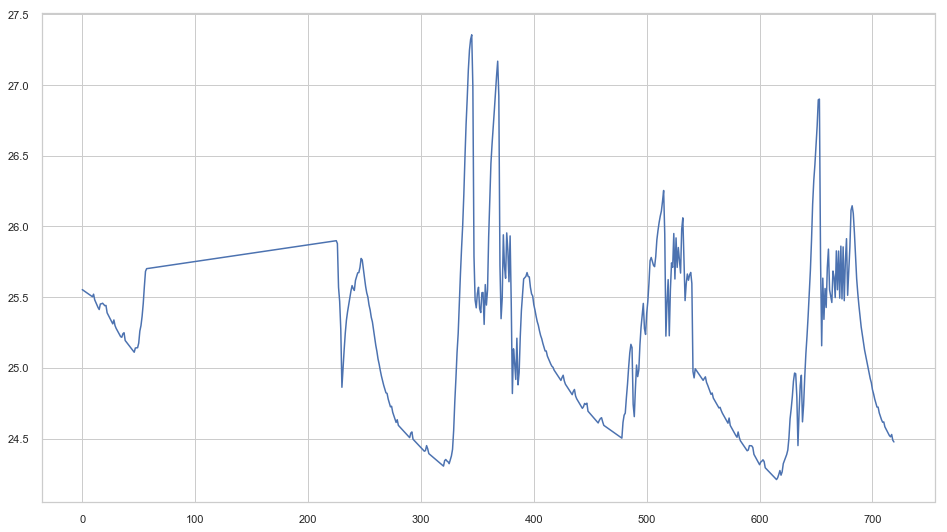

In [84]:
#dot notation x colchetes
fig, ax = plt.subplots(figsize=(16,9))
df_ADM_Temperature.Value.plot()

### Algumas Análises

In [85]:
df_ADM_Temperature['Value'].mean()

25.282572

In [86]:
index_max = df_ADM_Temperature.Value.idxmax()
index_max

345

In [87]:
temp_max = df_ADM_Temperature.Value[index_max]
temp_max

27.354706

In [88]:
timestamp_max = df_ADM_Temperature.Timestamp[index_max]
timestamp_max

Timestamp('2018-09-26 09:30:00-0300', tz='America/Sao_Paulo')

In [89]:
index_min = df_ADM_Temperature.Value.idxmin()
index_min

615

In [90]:
temp_min = df_ADM_Temperature.Value[index_min]
temp_min

24.21007

In [91]:
timestamp_min = df_ADM_Temperature.Timestamp[index_min]
timestamp_min

Timestamp('2018-09-28 06:30:00-0300', tz='America/Sao_Paulo')

In [92]:
anomalia1_timestamp = df_ADM_Temperature.Timestamp[60]
anomalia1_temp = df_ADM_Temperature.Value[60]

#### Gerando Gráfico

In [93]:
#set a paleta de cores
plt.style.use('seaborn')

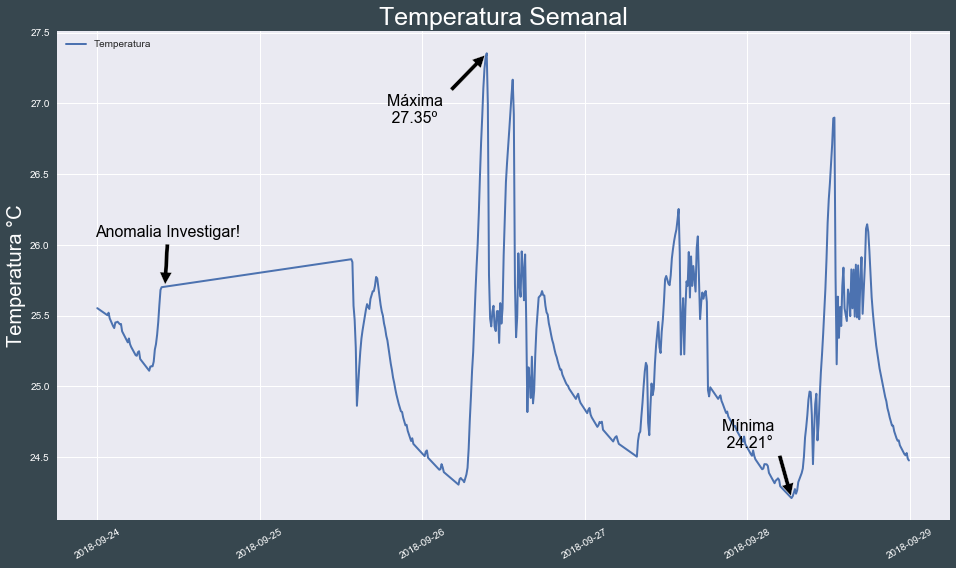

<Figure size 576x396 with 0 Axes>

In [94]:
fig, ax = plt.subplots(figsize=(16,9))

#configura eixo Y com os valores da Temperatura e o eixo X com os valores de Timestamp
ax.plot(df_ADM_Temperature.Timestamp, df_ADM_Temperature.Value, ls='-', lw=2, label='Temperatura')

ax.set_ylabel('Temperatura °C', color='white', fontsize = 20, horizontalalignment='center')

ax.set_title("Temperatura Semanal", fontsize=25,color='white')

ax.legend(loc='upper left')

ax.annotate('Mínima \n %.2f°'%temp_min,
            (timestamp_min, temp_min),
             xytext=(-70, 50), 
             textcoords='offset points',
             arrowprops=dict(facecolor='black', shrink=0.05),
             size=16, 
             color='Black'
            ) 

ax.annotate('Máxima \n %.2fº'%temp_max,
            (timestamp_max, temp_max),
             xytext=(-100, -70), 
             textcoords='offset points',
             #arrowprops=dict(arrowstyle='-|>', color='black'), 
            arrowprops=dict(facecolor='black', shrink=0.05),
             size=16, 
             color='Black'
            ) 

ax.annotate('Anomalia Investigar!',
            (anomalia1_timestamp, anomalia1_temp),
             xytext=(-70, 50), 
             textcoords='offset points',
             arrowprops=dict(facecolor='black', shrink=0.05),
             size=16, 
             color='Black'
            ) 

plt.xticks(rotation=30, color='white')
plt.yticks(color='white')

fig.patch.set_facecolor('#37474F')
fig.patch.set_edgecolor('#607d8b')

plt.show()
plt.clf()

In [95]:
from io import BytesIO
import mimetypes
import time

In [96]:
#cria conexao
epmConn = epm.EpmConnection('http://localhost:44333', 'http://localhost:44332', 'sa', 'Elipse21')
sio = BytesIO() 
fig.savefig(sio, format="png", facecolor='#37474F') 

epResourceManager = epmConn.getPortalResourcesManager()
reportPath = epResourceManager.getResource(u'webinar')
resource = reportPath.upload('chart_current.png', sio,
                                 'Figura enviada jupyter.',
                                 mimetypes.types_map['.png'], overrideFile=True)

path = 'update_img'
bv = epmConn.getDataObjects(path)
wResult = bv[path].write(0, datetime.now(), 0 )
time.sleep(2)
wResult = bv[path].write(1, datetime.now(), 0 )

epmConn.close()